## Simulating Channel flow

In [1]:
## imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import jax_cfd.base as cfd
import xarray

In [2]:
## setting up the model parameters and shape
#original
size = (512, 128)
domain = ((0, 8), (0, 2))

size = (256,64)
domain = ((0, 8), (0, 2))

density = 1. ### original 1.
viscosity = 1e-4 # kinematic viscosity ### original 1e-3

pressure_gradient = 2e-3  # uniform dP/dx ### original 2e-3

# Define the physical dimensions of the simulation.


In [3]:
## boundary conditions
# Specify periodic BC on x-boundaries, and no-slip walls on the y-boundaries. <- channel flow settings
velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

In [4]:
grid = cfd.grids.Grid(size, domain=domain)

masks = cfd.grids.domain_interior_masks(grid)

In [5]:
## pressure solver
pressure_solve = cfd.pressure.solve_fast_diag_channel_flow ### solve_fast_diag_channel_flow OR solve_cg

In [6]:
## initial velocity
def x_velocity_fn(x, y):
  return jnp.zeros_like(x + y) + 0.2 * np.random.normal(
      size=grid.shape) * masks[0]

def y_velocity_fn(x, y):
  return jnp.zeros_like(x + y) #+ 0.2 * np.random.normal(size=grid.shape) * masks[1]

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)

v0 = cfd.initial_conditions.initial_velocity_field(
           velocity_fns = (vx_fn, vy_fn),
           grid = grid,
           velocity_bc = velocity_bc,
           pressure_solve = pressure_solve,
           iterations=5)

''' 
v0 = cfd.initial_conditions.filtered_velocity_field(
    rng_key = jax.random.PRNGKey(11),
    grid = grid,
    iterations = 10
)
'''

' \nv0 = cfd.initial_conditions.filtered_velocity_field(\n    rng_key = jax.random.PRNGKey(11),\n    grid = grid,\n    iterations = 10\n)\n'

In [7]:
## divergence check
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

In [8]:
## time step
max_velocity = 1
cfl_safety_factor = 0.5

dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

In [9]:
dt

0.015625

In [10]:
## forcing

## Here are different types of forcing functions/conditions

# Linear force due to uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

# Turbulent forcing (kolmogorov forcing)
def turbulentForcing(grid):
    return cfd.forcings.simple_turbulence_forcing(grid, constant_magnitude = 0.5, linear_coefficient = -0.8) # params specified in jax-cfd for 2D turbulence

In [11]:
forcings = cfd.forcings.sum_forcings(
    pressure_gradient_forcing(pressure_gradient),
    #turbulentForcing(grid),
    cfd.forcings.taylor_green_forcing(grid, scale = 0.05)
    #cfd.forcings.kolmogorov_forcing(grid)
    #cfd.forcings.linear_forcing(grid,1.01)
    #cfd.forcings.filtered_forcing(grid = grid, spectral_density = 1)
    #cfd.forcings.filtered_linear_forcing(grid=grid, upper_wavenumber = 2, coefficient = 1, lower_wavenumber = 1)
)

In [12]:
## define convection function
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)

In [13]:
## step function

# time steps per output
inner_steps = 1_000

# number of outputs
outer_steps = 200
 
# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve = pressure_solve, # defined above for setting v0
        forcing= forcings
        #forcing = turbulentForcing(grid)
        ),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    step_fn, outer_steps, start_with_input=True))

In [14]:
## compute trajectory
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 5min 17s, sys: 15.5 s, total: 5min 32s
Wall time: 2min 48s


In [15]:
## load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

In [16]:
umax = max(ds.u.values.flatten())
L = domain[1][1]
nu = viscosity

Re = umax*L/nu
Re

561102.7908325195

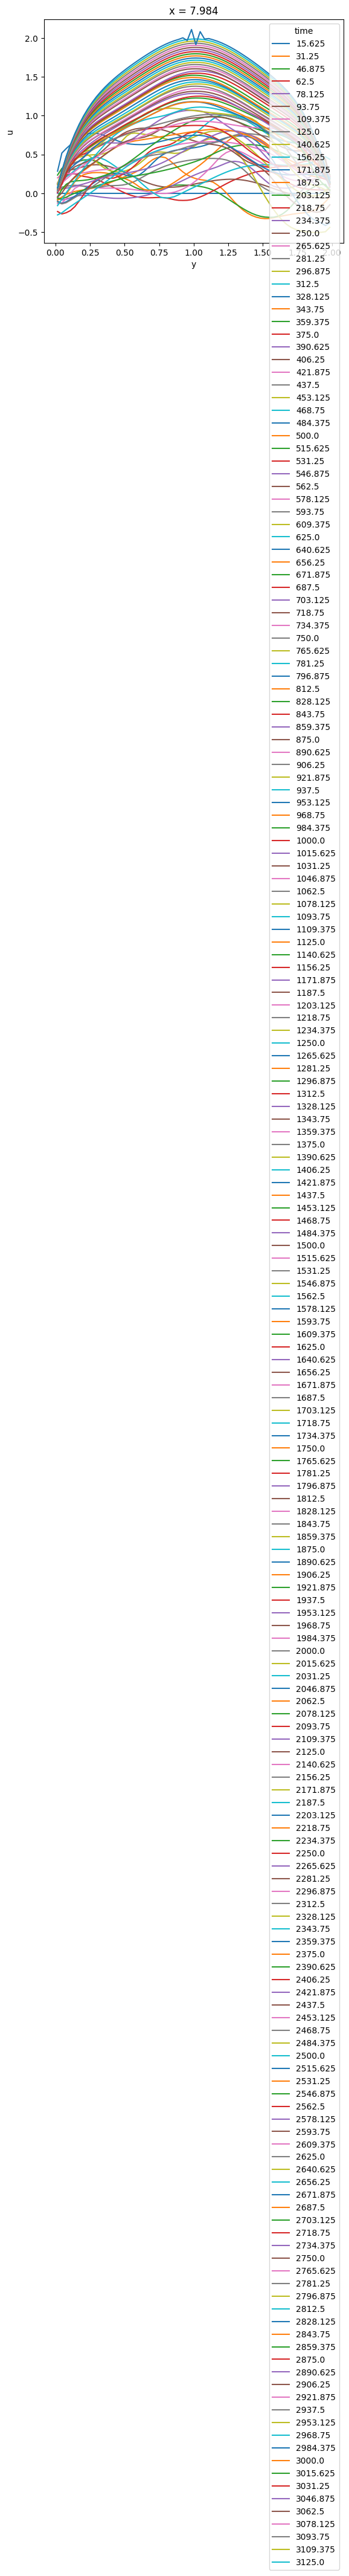

In [17]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')

/var/tmp/pbs.6975960.pbs/ipykernel_1414230/2151046737.py:10: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  xarray.plot.pcolormesh(u, 'x', 'y',cmap=seaborn.cm.rocket, col_wrap=4,ax=axs[i],robust=True);


IndexError: index 20 is out of bounds for axis 0 with size 20

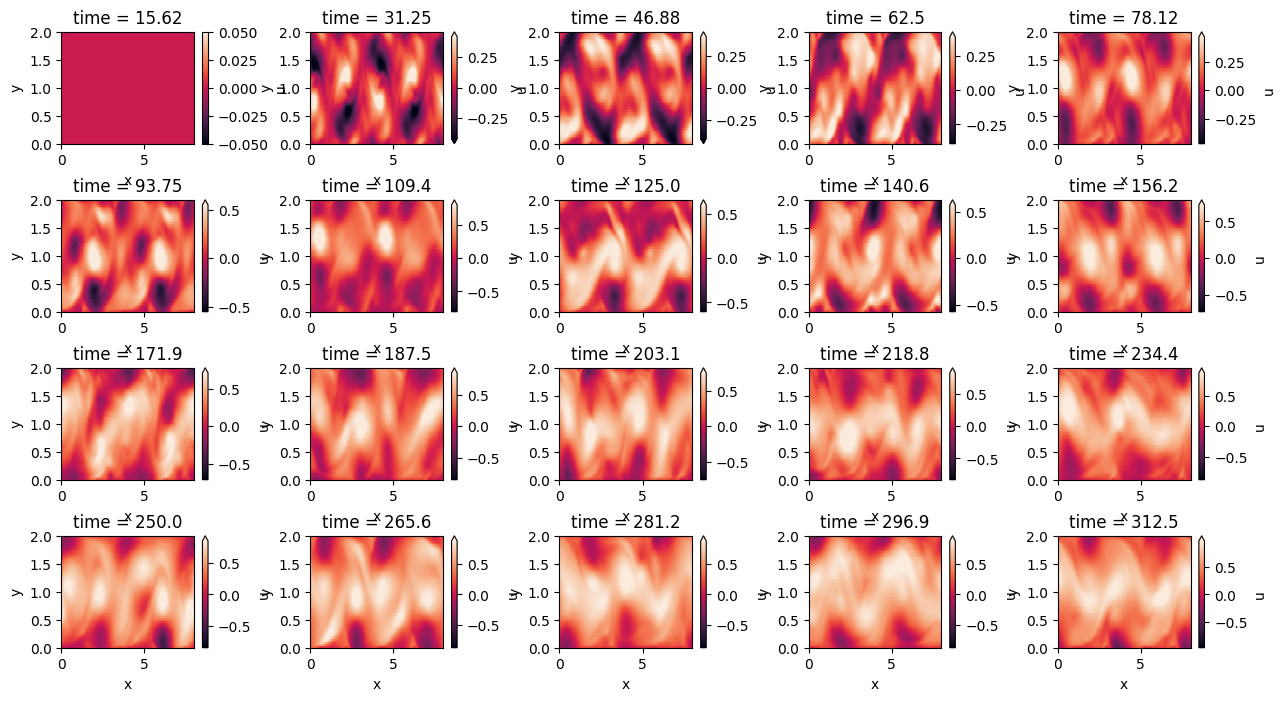

In [18]:
## plot u
fig, axs = plt.subplots(4,5, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()


for i in range(outer_steps):
    u = ds.u[i]
    xarray.plot.pcolormesh(u, 'x', 'y',cmap=seaborn.cm.rocket, col_wrap=4,ax=axs[i],robust=True);

/var/tmp/pbs.6975960.pbs/ipykernel_1414230/3609485364.py:10: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  xarray.plot.pcolormesh(v, 'x', 'y',cmap=seaborn.cm.rocket, col_wrap=4,ax=axs[i],robust=True);


IndexError: index 20 is out of bounds for axis 0 with size 20

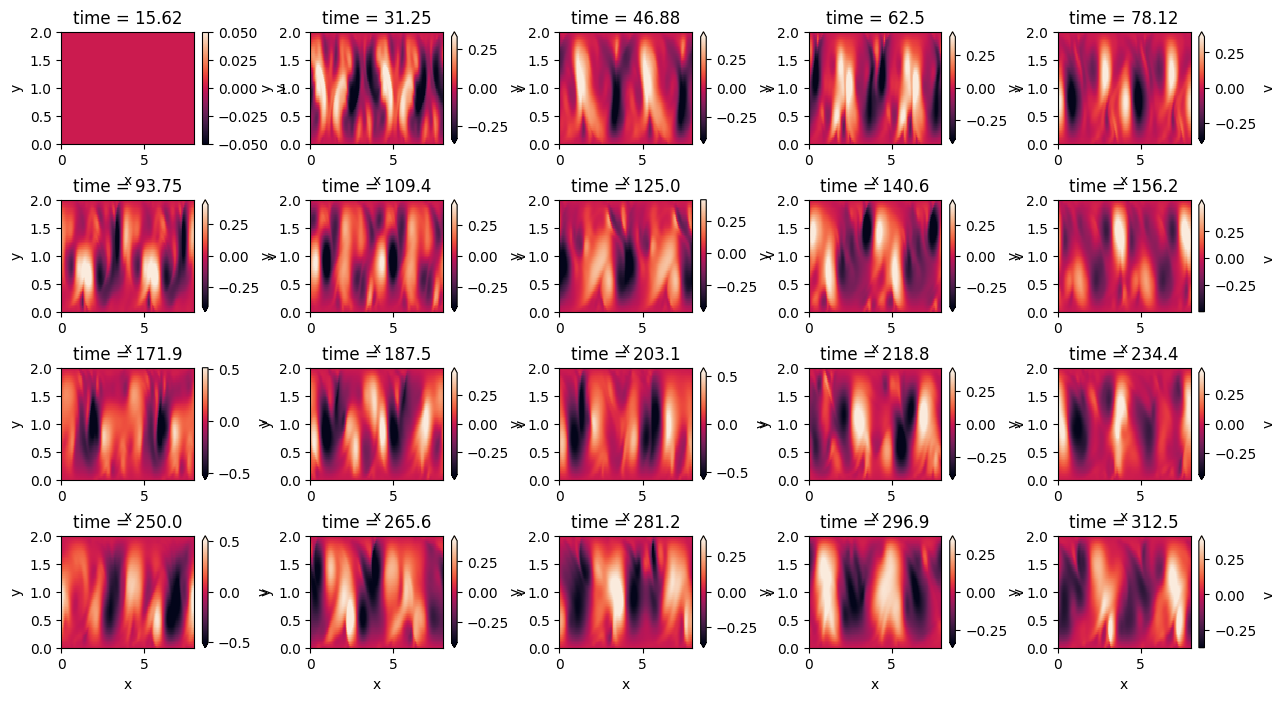

In [19]:
## plot v
fig, axs = plt.subplots(4,5, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()


for i in range(outer_steps):
    v = ds.v[i]
    xarray.plot.pcolormesh(v, 'x', 'y',cmap=seaborn.cm.rocket, col_wrap=4,ax=axs[i],robust=True);

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(15, 8), facecolor='w', edgecolor='k')

xarray.plot.pcolormesh(ds.u[0], 'x', 'y',cmap=seaborn.cm.rocket,robust=True, ax = axs);

In [ ]:
ds.v[18].values[-1,:]

In [ ]:
## calculate and plot vorticity
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

In [ ]:
## quiver plot of velocity
fig, axs = plt.subplots(4,5, figsize=(17, 13), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.5)

axs = axs.ravel()
for i in range(outer_steps):
    ds_plot = ds.isel(time=i)
    downsample_factor = 4 #divides by this
    ds_plot = ds_plot.coarsen(x=downsample_factor*2).mean().coarsen(y=downsample_factor).mean()
    ds_plot.plot.quiver(x='x', y='y', u='u', v='v', ax = axs[i], infer_intervals=True)

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(15, 8), facecolor='w', edgecolor='k')

#xarray.plot.pcolormesh(ds.u[19], 'x', 'y',cmap=seaborn.cm.rocket,robust=True, ax = axs);

ds_plot = ds.isel(time=17)

downsample_factor = 4 #divides by this
ds_plot = ds_plot.coarsen(x=downsample_factor*2).mean().coarsen(y=downsample_factor).mean()

ds_plot.plot.quiver(x='x', y='y', u='u', v='v', ax = axs, infer_intervals=True)

In [ ]:
ds1 = ds
downsample_factor = 4 #divides by this
ds2 = ds.coarsen(x=downsample_factor*2).mean().coarsen(y=downsample_factor).mean()

In [ ]:
ds.x.values[int(np.floor(len(ds.x.values)/2))]

In [ ]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time',add_legend=False)

In [ ]:
def vel_at_middle_of_channel(ds, ySize,xSize):
    return ds.isel(x= int(np.floor(xSize/3))).isel(y= int(np.floor(ySize/3)))

ySize = len(ds.y.values)
xSize = len(ds.x.values)

du = ds.u
u = du.pipe(vel_at_middle_of_channel,ySize,xSize)
dv = ds.v
v = dv.pipe(vel_at_middle_of_channel,ySize,xSize)


In [ ]:
plt.plot(u)


In [ ]:
dt = 3125/2000

x = np.linspace(1*dt,(2000-1)*dt,2000)


plt.plot(x,v)


In [ ]:
import scipy

In [ ]:
#half the sampling frequency is the maximum analysis range of psd (nyquist sample frequency theorem)
2000/31.25 /2

In [ ]:
#welch's method
f, Pxx_den = scipy.signal.welch(u,(2000/3125))
plt.loglog(f, Pxx_den)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

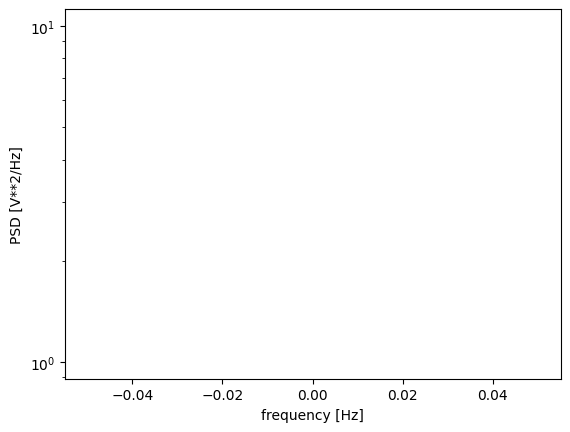

In [32]:
#welch's method
f, Pxx_den = scipy.signal.welch(v,(2000/3125))
plt.semilogy(f, Pxx_den)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

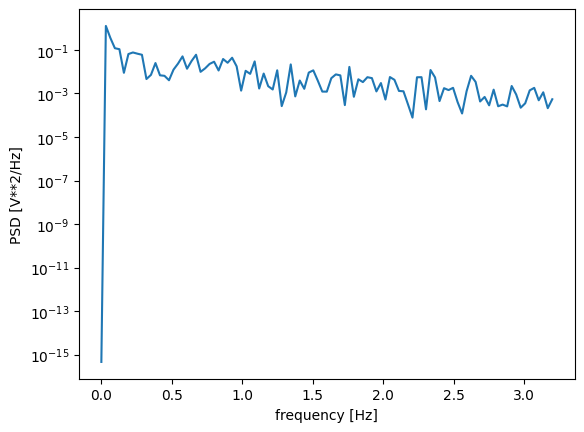

In [106]:
f, Pxx_den = scipy.signal.periodogram(u,200/31.25)
plt.semilogy(f, Pxx_den)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()